In [1]:
#importovanie kniznic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jsonlines
import json
from bs4 import BeautifulSoup
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import ttest_ind, f_oneway
from scipy.stats import pearsonr, spearmanr
from nltk.tokenize import sent_tokenize, word_tokenize
import emoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from collections import Counter #
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import spacy
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nlp = spacy.load('en_core_web_sm')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from scipy.sparse import hstack
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from langdetect import detect
from langdetect import LangDetectException
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from nltk import pos_tag
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/danielap/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/danielap/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/danielap/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/danielap/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/danielap/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/danielap/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Načítanie datasetu

In [2]:
data = []

# Otvorte súbor a načítajte každý riadok ako JSON objekt.
with open('../datasety/ocisteny_dataset.json', 'r') as file:
    for line in file:
        try:
            json_obj = json.loads(line)
            data.append(json_obj)
        except json.JSONDecodeError as e:
            print(f"Chyba pri dekódovaní JSON na riadku: {e}")

In [3]:
combined_data = pd.DataFrame(data)
combined_data.head()

,text,id,occupation,gender,fame,birthyear
0,"[People don't know the definition, and use phr...",11683,sports,male,star,1987
1,[Wrong place to play that game. @CuomoPrimeTim...,42738,creator,male,superstar,1970
2,[Happy Hump Day! (📸: @dolephoto ) https://t.co...,11006,sports,male,star,1988
3,"[There are actors,there are stars & then there...",28582,performer,male,rising,1990
4,[https://t.co/Xy7QVbaTlE on Sept 24 I wrote ab...,16463,sports,male,superstar,1962


Zistenie veku podľa roku narodenia a zaradenie do vekovej skupiny

In [4]:
current_year = datetime.now().year
combined_data['age'] = current_year - combined_data['birthyear']

bins = [0, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
combined_data['age_group'] = pd.cut(combined_data['age'], bins=bins, labels=labels, right=False)

In [5]:
combined_data.groupby(['age_group']).size()

age_group
0-29      192
30-39    1309
40-49    1225
50-59     870
60-69     562
70-79     303
80+        71
dtype: int64

In [6]:
dataset=combined_data.copy()

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4532 entries, 0 to 4531
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   text        4532 non-null   object  
 1   id          4532 non-null   int64   
 2   occupation  4532 non-null   object  
 3   gender      4532 non-null   object  
 4   fame        4532 non-null   object  
 5   birthyear   4532 non-null   int64   
 6   age         4532 non-null   int64   
 7   age_group   4532 non-null   category
dtypes: category(1), int64(3), object(4)
memory usage: 252.8+ KB


## EXTRAKCIA SEMANTICKYCH CRT

Ako prvé si urobím určité predspracovanie textu

In [8]:
def preprocess_text_first(text):
    if isinstance(text, list):
        text = ' '.join(text)
    stop_words = set(stopwords.words('english'))
    # Odstránenie URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Odstránenie užívateľských označení (@) a hashtagov (#)
    text = re.sub(r'@\w+|#\w+', '', text)
    # Odstránenie emoji
    text = emoji.replace_emoji(text, replace='')
     # Odstránenie Unicode kontrolných znakov
    text = re.sub(r'[\u0000-\u001F\u0080-\u009F]', '', text)
    # Odstránenie nových riadkov a tabulátorov
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    # Konverzia na malé písmená
    text = text.lower()
    # Tokenizácia
    tokens = word_tokenize(text)
    # Odstránenie stop slov
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [9]:
dataset['processed_text'] = dataset['text'].apply(preprocess_text_first)

PRIEMERNY POCET POZITIVNYCH, NEGATIVNYCH A NEUTRALNYCH SLOV NA TWEET

In [10]:
# Inicializácia analyzátora sentimentu
sid = SentimentIntensityAnalyzer()

def sentiment_word_counts(words):
    # Inicializácia počítadiel pre pozitívne, negatívne a neutrálné slová
    positive, negative, neutral = 0, 0, 0
    
    # Iterovanie cez zoznam slov
    for word in words:
        # Ak token nie je slovo, preskočí ho
        if not word.isalpha():
            continue
            
        # Vypočítanie sentimentu pre každé slovo
        score = sid.polarity_scores(word)
        
        # Kategorizácia slova ako pozitívneho, negatívneho alebo neutrálného na základe compound skóre
        if score['compound'] > 0.1:  # Ak je compound skóre nad 0.1, považuje sa slovo za pozitívne
            positive += 1
        elif score['compound'] < -0.1:  # Ak je compound skóre pod -0.1, považuje sa slovo za negatívne
            negative += 1
        else:  # Všetky ostatné slová (compound skóre medzi -0.1 a 0.1) sú považované za neutrálné
            neutral += 1
            
    # Funkcia vráti tuple s počtom pozitívnych, negatívnych a neutrálnych slov
    return positive, negative, neutral

In [11]:
dataset['positive'], dataset['negative'], dataset['neutral'] = zip(*dataset['processed_text'].apply(sentiment_word_counts))

In [12]:
dataset['average_positive_per_tweet'] = dataset.apply(
    lambda row: row['positive'] / len(row['text']) if len(row['text']) > 0 else 0, axis=1)
dataset['average_negative_per_tweet'] = dataset.apply(
    lambda row: row['negative'] / len(row['text']) if len(row['text']) > 0 else 0, axis=1)
dataset['average_neutral_per_tweet'] = dataset.apply(
    lambda row: row['neutral'] / len(row['text']) if len(row['text']) > 0 else 0, axis=1)#vydelenie počtom tweetov, ošetrenie proti deleniu 0

In [13]:
dataset['average_positive_per_tweet']

0       0.784416
1       1.068111
2       1.708029
3       1.352304
4       1.067368
          ...   
4527    1.378882
4528    0.479100
4529    0.383529
4530    1.219462
4531    1.011268
Name: average_positive_per_tweet, Length: 4532, dtype: float64

In [14]:
min_value = dataset['average_positive_per_tweet'].min()
max_value = dataset['average_positive_per_tweet'].max()
average_value = dataset['average_positive_per_tweet'].mean()

In [15]:
print("Najmenší prvok:", min_value)
print("Najväčší prvok:", max_value)
print("Priemerná hodnota:", average_value)

Najmenší prvok: 0.02
Najväčší prvok: 3.2596153846153846
Priemerná hodnota: 1.1290820961848516


In [16]:
 dataset['average_negative_per_tweet']

0       0.446753
1       1.095975
2       0.165450
3       0.189702
4       0.416842
          ...   
4527    0.599379
4528    0.221865
4529    0.437647
4530    1.064182
4531    0.695775
Name: average_negative_per_tweet, Length: 4532, dtype: float64

In [17]:
min_value = dataset['average_negative_per_tweet'].min()
max_value = dataset['average_negative_per_tweet'].max()
average_value = dataset['average_negative_per_tweet'].mean()

In [18]:
print("Najmenší prvok:", min_value)
print("Najväčší prvok:", max_value)
print("Priemerná hodnota:", average_value)

Najmenší prvok: 0.008948545861297539
Najväčší prvok: 2.0644171779141103
Priemerná hodnota: 0.31469313977045305


In [19]:
dataset['average_neutral_per_tweet']

0        5.129870
1        9.123839
2        4.783455
3        4.609756
4       11.496842
          ...    
4527     7.164596
4528     3.411576
4529     6.284706
4530    12.904762
4531    10.076056
Name: average_neutral_per_tweet, Length: 4532, dtype: float64

In [20]:
min_value = dataset['average_neutral_per_tweet'].min()
max_value = dataset['average_neutral_per_tweet'].max()
average_value = dataset['average_neutral_per_tweet'].mean()

In [21]:
print("Najmenší prvok:", min_value)
print("Najväčší prvok:", max_value)
print("Priemerná hodnota:", average_value)

Najmenší prvok: 0.5990566037735849
Najväčší prvok: 21.974736842105262
Priemerná hodnota: 6.187082185365688


PRIEMERNY POCET ENTIT NA TWEET (NAZVY ORGANIZACII, MENA..)

In [22]:
def count_entities(tokens):
    # Prevedie zoznam tokenov späť na textový reťazec
    text = ' '.join(tokens)
    
    # Spracovanie textu pomocou modelu spaCy
    doc = nlp(text)
    
    # Počítanie entít
    entities_count = len(doc.ents)
    
    return entities_count

In [23]:
dataset['entities_count'] = dataset['processed_text'].apply(count_entities)

In [24]:
dataset['average_entities_per_tweet'] = dataset.apply(lambda row: row['entities_count'] / len(row['text']) if len(row['text']) > 0 else 0, axis=1)#vydelenie počtom tweetov, ošetrenie delenim 0

In [25]:
dataset['average_entities_per_tweet']

0       0.205195
1       0.619195
2       0.557178
3       0.466125
4       2.364211
          ...   
4527    0.586957
4528    0.617363
4529    1.195294
4530    2.167702
4531    1.242254
Name: average_entities_per_tweet, Length: 4532, dtype: float64

In [26]:
min_value = dataset['average_entities_per_tweet'].min()
max_value = dataset['average_entities_per_tweet'].max()
average_value = dataset['average_entities_per_tweet'].mean()

In [27]:
print("Najmenší prvok:", min_value)
print("Najväčší prvok:", max_value)
print("Priemerná hodnota:", average_value)

Najmenší prvok: 0.05660377358490566
Najväčší prvok: 3.407624633431085
Priemerná hodnota: 0.77217233388553


PRIEMERNY SENTIMENT CLOVEKA

In [28]:
def calculate_average_sentiment(tweets):
    if len(tweets) == 0:
        return 0  # Ak nie sú žiadne tweety, vráti sa 0
    # Vypočítanie celkového sentimentu sumovaním compound skóre pre každý tweet
    # Compound skóre je agregátna hodnota, ktorá sumarizuje celkový sentiment tweetu
    total_sentiment_score = sum(sid.polarity_scores(tweet)['compound'] for tweet in tweets)
    return total_sentiment_score / len(tweets)

In [29]:
dataset['average_sentiment_score'] = dataset['processed_text'].apply(calculate_average_sentiment)

In [30]:
dataset['average_sentiment_score']

0       0.019379
1      -0.000972
2       0.076185
3       0.070260
4       0.014392
          ...   
4527    0.029896
4528    0.021743
4529   -0.002853
4530    0.001239
4531    0.006721
Name: average_sentiment_score, Length: 4532, dtype: float64

In [31]:
min_value = dataset['average_sentiment_score'].min()
max_value = dataset['average_sentiment_score'].max()
average_value = dataset['average_sentiment_score'].mean()

In [32]:
print("Najmenší prvok:", min_value)
print("Najväčší prvok:", max_value)
print("Priemerná hodnota:", average_value)

Najmenší prvok: -0.04067714631197105
Najväčší prvok: 0.26737759078831164
Priemerná hodnota: 0.03762712710076476


Dalšie spracovanie

In [33]:
def lemmatize_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    # Spracovanie textu pomocou modelu spaCy
    doc = nlp(text)
    # Extrahovanie lemmatizovaných tokenov a odstránenie interpunkcie a medzier
    lemmatized = [token.lemma_ for token in doc if not token.is_punct | token.is_space]
    # Spojenie lemmatizovaných tokenov späť do reťazca
    return lemmatized

In [34]:
dataset['lemmatized_text'] = dataset['processed_text'].apply(lemmatize_text)

PRIEMERNY POCET NEGATIVNYCH, KOGNITYVNYCH A SENZOROVYCH SLOV NA TWEET

In [35]:
# Funkcia na počítanie negačných slov v zozname tokenov
def count_negations(tokens):
    # Definícia množiny negačných slov
    negation_words = {
        'not', 'no', 'never', 'nothing', 'none', 'neither', 'nor', 'nowhere', 'cannot', 'cant',
        'dont', 'doesnt', 'isnt', 'arent', 'wont', 'wasnt', 'werent', 'havent', 'hasnt', 'hadnt',
        'nobody', 'nín', 'naught', 'without', 'lack', 'missing', 'sans', 'void', 'minus', 'failed'
    }
    # Počíta počet výskytov negačných slov v zozname tokenov
    return sum(token.lower() in negation_words for token in tokens)

# Funkcia na počítanie slov spojených s kognitívnymi procesmi
def count_cognitive_words(tokens):
    # Definícia množiny slov, ktoré súvisia s myslením alebo poznávaním
    cognitive_words = {'think', 'understand', 'know', 'believe', 'remember', 'imagine'}
    # Počíta počet výskytov kognitívnych slov v zozname tokenov
    return sum(token.lower() in cognitive_words for token in tokens)

# Funkcia na počítanie slov, ktoré sú spojené so zmyslovými percepciami
def count_sensory_words(tokens):
    # Definícia množiny slov súvisiacich so zmyslami
    sensory_words = {'see', 'hear', 'feel', 'taste', 'smell', 'touch', 'watch', 'observe', 'listen', 'sense'}
    # Počíta počet výskytov zmyslových slov v zozname tokenov
    return sum(token.lower() in sensory_words for token in tokens)


In [36]:
dataset['negation_count'] = dataset['lemmatized_text'].apply(count_negations)
dataset['cognitive_word_count'] = dataset['lemmatized_text'].apply(count_cognitive_words)
dataset['sensory_word_count'] = dataset['lemmatized_text'].apply(count_sensory_words)

In [37]:
dataset['average_negation_per_tweet'] = dataset.apply(
    lambda row: row['negation_count'] / len(row['text']) if len(row['text']) > 0 else 0, axis=1)
dataset['average_cognitive_word_per_tweet'] = dataset.apply(
    lambda row: row['cognitive_word_count'] / len(row['text']) if len(row['text']) > 0 else 0, axis=1)
dataset['average_sensory_word_per_tweet'] = dataset.apply(
    lambda row: row['sensory_word_count'] / len(row['text']) if len(row['text']) > 0 else 0, axis=1)#predelenie po4tom tweetov, o3etrene delenim 0

In [38]:
min_value = dataset['average_negation_per_tweet'].min()
max_value = dataset['average_negation_per_tweet'].max()
average_value = dataset['average_negation_per_tweet'].mean()

In [39]:
print("Najmenší prvok:", min_value)
print("Najväčší prvok:", max_value)
print("Priemerná hodnota:", average_value)

Najmenší prvok: 0.0
Najväčší prvok: 0.5501113585746102
Priemerná hodnota: 0.08109711126464024


In [40]:
min_value = dataset['average_cognitive_word_per_tweet'].min()
max_value = dataset['average_cognitive_word_per_tweet'].max()
average_value = dataset['average_cognitive_word_per_tweet'].mean()

In [41]:
print("Najmenší prvok:", min_value)
print("Najväčší prvok:", max_value)
print("Priemerná hodnota:", average_value)

Najmenší prvok: 0.0
Najväčší prvok: 0.6711229946524064
Priemerná hodnota: 0.07423867566837998


In [42]:
min_value = dataset['average_sensory_word_per_tweet'].min()
max_value = dataset['average_sensory_word_per_tweet'].max()
average_value = dataset['average_sensory_word_per_tweet'].mean()

In [43]:
print("Najmenší prvok:", min_value)
print("Najväčší prvok:", max_value)
print("Priemerná hodnota:", average_value)

Najmenší prvok: 0.0
Najväčší prvok: 0.6761710794297352
Priemerná hodnota: 0.10630656057524293


VYMAZANIE NEPOTREBNYCH STLPCOV

In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4532 entries, 0 to 4531
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   text                              4532 non-null   object  
 1   id                                4532 non-null   int64   
 2   occupation                        4532 non-null   object  
 3   gender                            4532 non-null   object  
 4   fame                              4532 non-null   object  
 5   birthyear                         4532 non-null   int64   
 6   age                               4532 non-null   int64   
 7   age_group                         4532 non-null   category
 8   processed_text                    4532 non-null   object  
 9   positive                          4532 non-null   int64   
 10  negative                          4532 non-null   int64   
 11  neutral                           4532 non-null   int64 

In [45]:
dataset=dataset.drop([ 'occupation',  'fame','birthyear', 'age', 'text','processed_text',  'positive','negative', 'neutral', 'entities_count','lemmatized_text',  'negation_count','cognitive_word_count', 'sensory_word_count' ], axis=1)

In [46]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4532 entries, 0 to 4531
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   id                                4532 non-null   int64   
 1   gender                            4532 non-null   object  
 2   age_group                         4532 non-null   category
 3   average_positive_per_tweet        4532 non-null   float64 
 4   average_negative_per_tweet        4532 non-null   float64 
 5   average_neutral_per_tweet         4532 non-null   float64 
 6   average_entities_per_tweet        4532 non-null   float64 
 7   average_sentiment_score           4532 non-null   float64 
 8   average_negation_per_tweet        4532 non-null   float64 
 9   average_cognitive_word_per_tweet  4532 non-null   float64 
 10  average_sensory_word_per_tweet    4532 non-null   float64 
dtypes: category(1), float64(8), int64(1), object(1)
memory u

KATEGORICKE STLPCE

Ideme zmeniť nenumerické stlpce na numerické aby som ich vedela použiť v strojovom učení (age_group). Text a Processed_text nemeníme, kedže ich neskôr vymažeme, ked už nebudú potrebné

In [47]:
le = LabelEncoder()
dataset['age_group'] = le.fit_transform(dataset['age_group'])
dataset['gender'] = le.fit_transform(dataset['gender'])

In [48]:
dataset.head(10)

,id,gender,age_group,average_positive_per_tweet,average_negative_per_tweet,average_neutral_per_tweet,average_entities_per_tweet,average_sentiment_score,average_negation_per_tweet,average_cognitive_word_per_tweet,average_sensory_word_per_tweet
0,11683,1,1,0.784416,0.446753,5.129870,0.205195,0.019379,0.480519,0.129870,0.122078
1,42738,1,3,1.068111,1.095975,9.123839,0.619195,-0.000972,0.130031,0.198142,0.232198
2,11006,1,1,1.708029,0.165450,4.783455,0.557178,0.076185,0.026764,0.060827,0.111922
3,28582,1,1,1.352304,0.189702,4.609756,0.466125,0.070260,0.056911,0.027100,0.084011
4,16463,1,4,1.067368,0.416842,11.496842,2.364211,0.014392,0.086316,0.155789,0.082105
5,3691,0,3,1.146597,0.188482,6.044503,1.007853,0.042360,0.041885,0.086387,0.133508
6,37297,1,2,1.142857,0.544643,8.416667,0.752976,0.015912,0.122024,0.139881,0.083333
7,5939,0,1,1.940397,0.741722,6.933775,0.433775,0.039608,0.039735,0.192053,0.135762
8,14209,0,1,0.962529,0.138173,5.290398,0.690867,0.037321,0.086651,0.028103,0.121780
9,45388,1,4,0.814815,0.335648,8.782407,1.601852,0.013947,0.175926,0.115741,0.060185


In [49]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4532 entries, 0 to 4531
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                4532 non-null   int64  
 1   gender                            4532 non-null   int64  
 2   age_group                         4532 non-null   int64  
 3   average_positive_per_tweet        4532 non-null   float64
 4   average_negative_per_tweet        4532 non-null   float64
 5   average_neutral_per_tweet         4532 non-null   float64
 6   average_entities_per_tweet        4532 non-null   float64
 7   average_sentiment_score           4532 non-null   float64
 8   average_negation_per_tweet        4532 non-null   float64
 9   average_cognitive_word_per_tweet  4532 non-null   float64
 10  average_sensory_word_per_tweet    4532 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 389.6 KB


In [50]:
dataset.to_json("semanticke_crty_ocisteny.json", orient='records', lines=True)

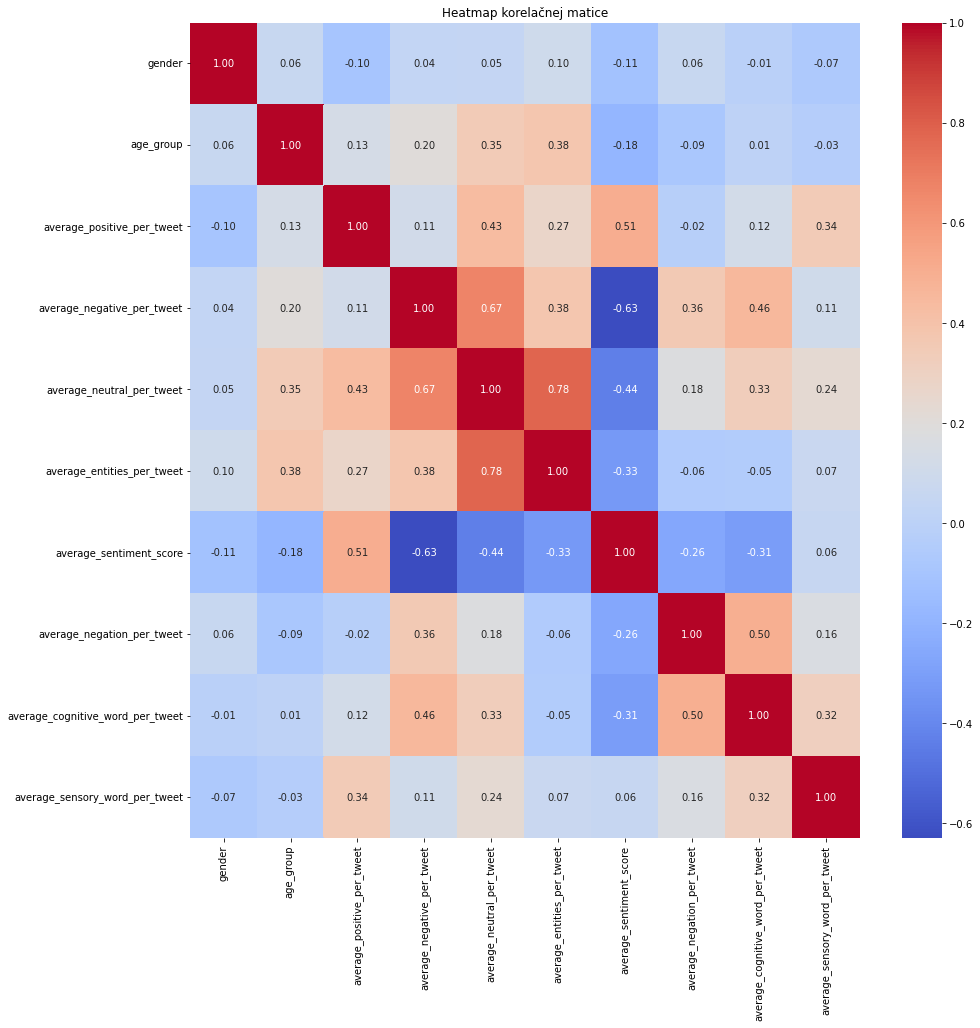

In [51]:
dataset_corr=dataset.drop([ 'id'], axis=1)
corr_matrix = dataset_corr.corr()

# Vytvor heatmap
plt.figure(figsize=(15, 15))  # Nastav veľkosť obrázka podľa potreby
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap korelačnej matice')
plt.show()